First we are going to import all the libraries we need

In [204]:

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split
import pandas as pd


Now we are going to load the datset

In [205]:
filepath = '/Users/ritika/Downloads/GNN-Tutorial-main/'
dataset_path = filepath+'simulator_data.csv'

# Load the dataset
data = pd.read_csv(dataset_path)

Now we will implement some basic helper functions that we need

In [206]:
# Function to compute the distance between two points
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

In [207]:
# Function to check for handovers between timestamps
def check_handovers(df, current_timestamp, next_timestamp):
    current_data = df[df['timestamp'] == current_timestamp]
    next_data = df[df['timestamp'] == next_timestamp]

    handovers = {}
    for vid in current_data['vehicleId'].unique():
        current_master = current_data[current_data['vehicleId'] == vid]['masterId'].iloc[0]
        next_master = next_data[next_data['vehicleId'] == vid]['masterId'].iloc[0] if vid in next_data['vehicleId'].values else current_master
        handovers[vid] = current_master != next_master

    return handovers

Lets create our Graph

In [208]:
# Function to create a graph data object and NetworkX graph for a given timestamp
def create_graph_data_for_timestamp(df, timestamp):
    print("timestamp")
    print(timestamp)
    timestamp_data = df[df['timestamp'] == timestamp]
    vehicle_ids = timestamp_data['vehicleId'].unique()
    #print('number of vehicles:', vehicle_ids.size)
    tower_ids = timestamp_data['towerId'].unique()
    #print('number of towers:', tower_ids.size)
    vehicle_mapping = {vid: i for i, vid in enumerate(vehicle_ids)}
    tower_mapping = {tid: i + len(vehicle_ids) for i, tid in enumerate(tower_ids)}

    node_features = []
    edge_index = []
    edge_features = []

    G = nx.Graph()  # NetworkX Graph for visualization

    # Process vehicle nodes
    for vid in vehicle_ids:
        try:
            vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[2]
        except IndexError:
            try:
                vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[1]
            except IndexError:
                vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[0]
        vehicle_data = timestamp_data[timestamp_data['vehicleId'] == vid].iloc[0]
        vehicle_features = [
            vehicle_data['vehicleSpeed'], vehicle_data['vehicleDirection'], vehicle_data['vehiclePosX'],
            vehicle_data['vehiclePosY']
        ]
        node_features.append(vehicle_features)
        G.add_node(vehicle_mapping[vid], speed=vehicle_data['vehicleSpeed'], dir=vehicle_data['vehicleDirection'], 
                  pos=(vehicle_data['vehiclePosX'], vehicle_data['vehiclePosY']),
                   type='vehicle', label=f'{vid}')

    # Process tower nodes
    for tid in tower_ids:
        master_data = timestamp_data[timestamp_data['masterId'] == tid][::-1]
        if not master_data.empty:
            tower_data = master_data.iloc[0]
            tower_features = [
                tower_data['masterPosX'], tower_data['masterPosY'],
                tower_data['masterLoad'], 0.0  # Placeholder values for missing features
            ]
            G.add_node(tower_mapping[tid], pos=(tower_data['masterPosX'], tower_data['masterPosY']), load=tower_data['masterLoad'],
                    type='tower', label=f'T{tid}')
        else:
            tower_data = timestamp_data[timestamp_data['towerId'] == tid][::-1].iloc[0]
            tower_features = [
                tower_data['towerPosX'], tower_data['towerPosY'],
                tower_data['towerLoad'], 0.0  # Placeholder values for missing features
            ]
            G.add_node(tower_mapping[tid], pos=(tower_data['towerPosX'], tower_data['towerPosY']), load=tower_data['towerLoad'],
                        type='tower', label=f'T{tid}')

        node_features.append(tower_features)
        

    # Add edges based on the masterId
    for _, row in timestamp_data.iterrows():
        vehicle_id = vehicle_mapping[row['vehicleId']]
        tower_id = tower_mapping[row['masterId']]  # Connect to the master tower
        edge_index.append([vehicle_id, tower_id])
        

        distance = calculate_distance(row['vehiclePosX'], row['vehiclePosY'],
                                      row['masterPosX'], row['masterPosY'])
        edge_features.append([row['throughput'], row['masterRssi'], distance])

        # Add edges to the NetworkX graph
        G.add_edge(vehicle_id, tower_id, throughput=row['throughput'],  rssi=row['masterRssi'], distance=distance)
    
    node_features_tensor = torch.tensor(node_features, dtype=torch.float)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    # print(edge_index_tensor)
    # print(len(edge_index))
    edge_features_tensor = torch.tensor(edge_features, dtype=torch.float)

    graph_data = Data(x=node_features_tensor, edge_index=edge_index_tensor, edge_attr=edge_features_tensor)
    #print("node features: ", graph_data.x.shape,"edge index: ", graph_data.edge_index.shape,"edge attr: ", graph_data.edge_attr.shape)
    return graph_data, G, vehicle_mapping, tower_mapping

Graph Visualization

In [209]:
# Visualization function
def visualize_graph(G, handovers, vehicle_mapping, tower_mapping):
    # Set node attributes for vehicle and tower IDs and colors
    for node in G.nodes:
        node_info = G.nodes[node]
        node_type = node_info['type']
        if node_type == 'vehicle':
            label = node_info['label']
            color = 'lightblue'  # Color for vehicles
        elif node_type == 'tower':
            label = node_info['label']
            color = 'lightgreen'  # Color for towers
        else:
            label = 'Unknown'
            color = 'gray'

        G.nodes[node]['label'] = label
        G.nodes[node]['color'] = color

    # Highlight handover nodes
    for vehicle_id, handover in handovers.items():
        if handover:
            node = vehicle_mapping.get(vehicle_id)
            if node is not None:
                G.nodes[node]['color'] = 'lightpink'  # Highlight color for handovers

    # Set edge attributes for master RSSI
    for u, v in G.edges:
        edge_data = G[u][v]
        # Ensure that the 'masterRssi' key is correctly named as per your data
        master_rssi = edge_data.get('rssi', 0.0)  # Default to 'N/A' if not available
        G.edges[u, v]['label'] = str(int(master_rssi))

    # Prepare colors for nodes
    node_colors = [G.nodes[node]['color'] for node in G.nodes]

    # Visualize the graph
    pos = nx.get_node_attributes(G, 'pos')
    scale_factor = 100
    # Scale the x and y coordinates of each node
    scaled_pos = {node: (x * scale_factor, y * scale_factor) for node, (x, y) in pos.items()}
    nx.set_node_attributes(G, scaled_pos, 'pos')

    nx.draw(G, pos=scaled_pos, node_color=node_colors, with_labels=True, labels=nx.get_node_attributes(G, 'label'),font_size=8, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos=scaled_pos, edge_labels=nx.get_edge_attributes(G, 'label'),font_size=8)

    
def visualize_for_timestamp_range(df, start_timestamp, end_timestamp=None):
    if end_timestamp is not None:
        # Visualize graphs for the specified range
        timestamps = df['timestamp'].unique()
        timestamps_in_range = [t for t in timestamps if start_timestamp <= t <= end_timestamp]

        for timestamp in timestamps_in_range:
            # Get the next timestamp in the sequence for handover comparison
            next_timestamp_index = np.where(timestamps == timestamp)[0][0] + 1
            if next_timestamp_index < len(timestamps):
                next_timestamp = timestamps[next_timestamp_index]
            else:
                next_timestamp = timestamp  # No handover if it's the last timestamp

            # Check for handovers and create the graph for the current timestamp
            handovers = check_handovers(df, timestamp, next_timestamp)
            _, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(df, timestamp)

            # Visualize the graph
            plt.figure(figsize=(12, 8))
            visualize_graph(G, handovers, vehicle_mapping, tower_mapping)
            plt.title(f'Network Graph at Timestamp {timestamp}')
            plt.show()
    else:
        # Visualize a single graph for start_timestamp to start_timestamp + 0.5
        _, G, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(df, start_timestamp)   
        handovers = check_handovers(df, start_timestamp, start_timestamp + 0.5) 
        plt.figure(figsize=(12, 8))
        visualize_graph(G, handovers, vehicle_mapping, tower_mapping)
        plt.title(f'Network Graph at Timestamp {start_timestamp}')
        plt.show()

timestamp
70


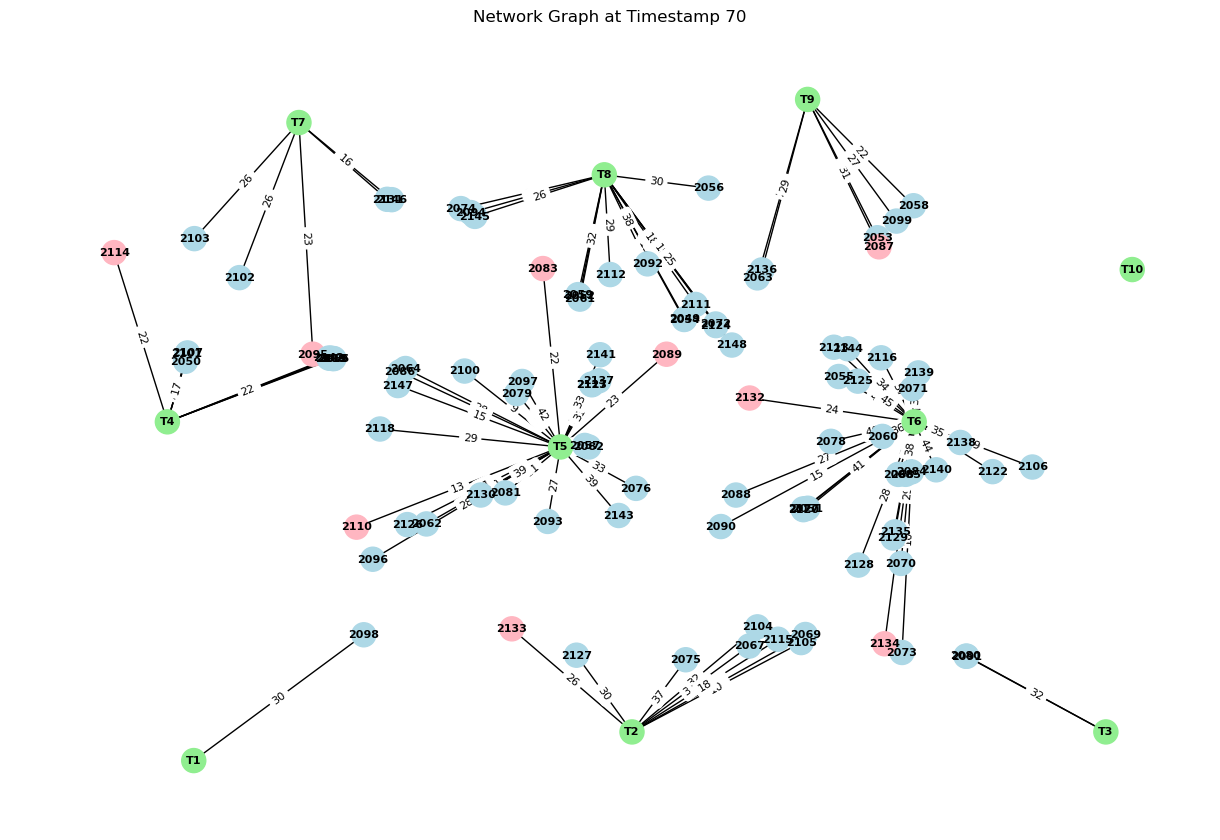

In [210]:
visualize_for_timestamp_range(data, start_timestamp=70)

Building GNN model

In [211]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, hidden_channels, out_channels, K):
        super(TemporalGNN, self).__init__()
        self.gconvgru = GConvGRU(in_channels=node_features, out_channels=hidden_channels, K =K)
        self.linear = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.gconvgru(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

Loss Function

In [212]:
def triplet_loss(anchor, positive, negative, margin=1.0):
    distance_positive = (anchor - positive).pow(2).sum(1)
    distance_negative = (anchor - negative).pow(2).sum(1)
    losses = F.relu(distance_positive - distance_negative + margin)
    return losses.mean()

In [213]:
import random

def get_triplets(data, embeddings, vehicle_mapping, tower_mapping):
    anchors = []
    positives = []
    negatives = []

    # print(data.edge_index)
    for vehicle_id in vehicle_mapping.values():
        # vehicle_idx = vehicle_mapping[vehicle_id]
        # print(vehicle_idx)

        # Get the indices of towers connected to this vehicle (positive samples)
        # connected_towers = [tower_mapping[tid] for tid in data.edge_index[1][data.edge_index[0] == vehicle_idx].tolist()]
        connected_towers = data.edge_index[1][data.edge_index[0] == vehicle_id].tolist()

        if not connected_towers:
            continue

        # Select one connected tower as positive
        positive_idx = random.choice(connected_towers)

        num_embeddings = embeddings.size(0)

        # Select one non-connected tower as negative
        non_connected_towers = list(set(tower_mapping.values()) - set(connected_towers))
        if not non_connected_towers:
            continue
        negative_idx = random.choice(non_connected_towers)

        if vehicle_id >= num_embeddings or positive_idx >= num_embeddings or negative_idx >= num_embeddings:
            #print(f"Skipping due to invalid index: vehicle_id={vehicle_id}, positive_idx={positive_idx}, negative_idx={negative_idx}")
            continue

        
        anchors.append(embeddings[vehicle_id])
        positives.append(embeddings[positive_idx])
        negatives.append(embeddings[negative_idx])
    

    if anchors and positives and negatives:  # Check if any triplets were collected
        anchors = torch.stack(anchors)
        positives = torch.stack(positives)
        negatives = torch.stack(negatives)

        return anchors, positives, negatives
    else:
        return None, None, None

Training the model

In [214]:
train_time = 10
test_time = 10.5

train_data = data[data['timestamp'] <= train_time]
#train_data = data[data['timestamp'] == train_time]
test_data = data[data['timestamp'] == test_time]

#train_graphs = [create_graph_data_for_timestamp(train_data, ts) for ts in train_data['timestamp'].unique()]
#train_graph_data, train_G, train_vehicle_mapping, train_tower_mapping = create_graph_data_for_timestamp(data,train_time)
#edgeF, _, _, _ = create_graph_data_for_timestamp(data,train_time)
#test_graphs = [create_graph_data_for_timestamp(test_data, ts) for ts in test_data['timestamp'].unique()]
train_graph_data = []
test_graph_data, _, vehicle_mapping, tower_mapping = create_graph_data_for_timestamp(test_data,test_time )

timestamp
10.5


In [215]:

for ts in train_data['timestamp'].unique():
    graphData, _, _, _ = create_graph_data_for_timestamp(train_data, ts)
    #print(graphData)
    #print(type(graphData))
    train_graph_data.append(graphData)
print(train_graph_data)

timestamp
0.5
timestamp
1.0
timestamp
1.5
timestamp
2.0
timestamp
2.5
timestamp
3.0
timestamp
3.5
timestamp
4.0
timestamp
4.5
timestamp
5.0
timestamp
5.5
timestamp
6.0
timestamp
6.5
timestamp
7.0
timestamp
7.5
timestamp
8.0
timestamp
8.5
timestamp
9.0
timestamp
9.5
timestamp
10.0
[Data(x=[41, 4], edge_index=[2, 54], edge_attr=[54, 3]), Data(x=[91, 4], edge_index=[2, 146], edge_attr=[146, 3]), Data(x=[109, 4], edge_index=[2, 182], edge_attr=[182, 3]), Data(x=[109, 4], edge_index=[2, 182], edge_attr=[182, 3]), Data(x=[109, 4], edge_index=[2, 182], edge_attr=[182, 3]), Data(x=[109, 4], edge_index=[2, 182], edge_attr=[182, 3]), Data(x=[109, 4], edge_index=[2, 182], edge_attr=[182, 3]), Data(x=[109, 4], edge_index=[2, 182], edge_attr=[182, 3]), Data(x=[110, 4], edge_index=[2, 184], edge_attr=[184, 3]), Data(x=[110, 4], edge_index=[2, 185], edge_attr=[185, 3]), Data(x=[110, 4], edge_index=[2, 186], edge_attr=[186, 3]), Data(x=[110, 4], edge_index=[2, 185], edge_attr=[185, 3]), Data(x=[110, 4

In [216]:
# Create a DataLoader
train_loader = DataLoader([train_graph_data], batch_size=32, shuffle=True)
#test_loader = DataLoader([test_graph_data], batch_size=32)

In [217]:
K = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalGNN(node_features=train_graph_data[1].num_node_features, hidden_channels=64, out_channels=32, K=K).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(200):
    model.train()
    total_loss = 0

    for gdata in train_loader:
        for data in gdata:
            optimizer.zero_grad()
            embeddings = model(data.x, data.edge_index)
            anchors, positives, negatives = get_triplets(data, embeddings, vehicle_mapping, tower_mapping)
            if anchors is not None and positives is not None and negatives is not None:
                loss = triplet_loss(anchors, positives, negatives)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
        #print(data)
        #data = data.to(device)
        ###optimizer.zero_grad()
        #print(x)
        #print(data.x)
        #print(x.shape)
        #print(edge_index)
        #print(edge_weight)
        #embeddings = model(x, edge_index, edge_weight)
        ###embeddings = model(data.x, data.edge_index)
        #print(embeddings.shape)
        """
        anchors, positives, negatives = get_triplets(data, embeddings, vehicle_mapping, tower_mapping)
        if anchors is not None and positives is not None and negatives is not None:
            loss = triplet_loss(anchors, positives, negatives)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            #print(f"Skipping batch due to no valid triplets in epoch {train_graph_data}")
        """
        #loss = triplet_loss(anchors, positives, negatives)
        
        #loss.backward()
        #optimizer.step()
        #total_loss += loss.item()

    #print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_data)}')
    print(f'Epoch {epoch+1}, Loss: {total_loss}')

Epoch 1, Loss: 17.964589536190033
Epoch 2, Loss: 15.707767486572266
Epoch 3, Loss: 13.393840789794922
Epoch 4, Loss: 11.925055027008057
Epoch 5, Loss: 10.433885097503662
Epoch 6, Loss: 9.797331362962723
Epoch 7, Loss: 8.795300781726837
Epoch 8, Loss: 8.162534445524216
Epoch 9, Loss: 7.886816054582596
Epoch 10, Loss: 7.4018236100673676
Epoch 11, Loss: 6.957406848669052
Epoch 12, Loss: 6.6474785804748535
Epoch 13, Loss: 7.3203622698783875
Epoch 14, Loss: 6.450978934764862
Epoch 15, Loss: 6.362070024013519
Epoch 16, Loss: 6.118756502866745
Epoch 17, Loss: 5.613976240158081
Epoch 18, Loss: 5.9019012451171875
Epoch 19, Loss: 5.241443112492561
Epoch 20, Loss: 5.642778187990189
Epoch 21, Loss: 5.519263327121735
Epoch 22, Loss: 5.48021337389946
Epoch 23, Loss: 5.298099368810654
Epoch 24, Loss: 5.308180883526802
Epoch 25, Loss: 5.3669231832027435
Epoch 26, Loss: 4.915615558624268
Epoch 27, Loss: 5.088446244597435
Epoch 28, Loss: 4.98307803273201
Epoch 29, Loss: 4.547602042555809
Epoch 30, Loss:

Getting the top towers for handover

In [218]:

vehicle_indices = list(vehicle_mapping.values())
tower_indices = list(tower_mapping.values())

vehicle_embeddings = embeddings[vehicle_indices]
tower_embeddings = embeddings[tower_indices]

# Convert PyTorch tensors to NumPy arrays using detach().numpy()
vehicle_embeddings = vehicle_embeddings.detach().numpy()
tower_embeddings = tower_embeddings.detach().numpy()
# print(vehicle_embeddings)

# Calculate cosine similarity between each vehicle and all towers
similarity_matrix = cosine_similarity(vehicle_embeddings, tower_embeddings)

top_3_candidates = {}
for i, vehicle_id in enumerate(vehicle_mapping.keys()):
    # Get indices of top 3 towers based on similarity
    top_towers_indices = np.argsort(similarity_matrix[i])[::-1][:3]
    
    print(f'Vehicle {vehicle_id} top handover for next timestamp will be {top_towers_indices}')
    # Map indices back to tower IDs
    # print(top_towers_indices)
    # top_towers_ids = [list(tower_mapping.keys())[list(tower_mapping.keys()).index(idx)] for idx in top_towers_indices]

    top_3_candidates[vehicle_id] = top_towers_indices


Vehicle 2065 top handover for next timestamp will be [4 7 0]
Vehicle 2110 top handover for next timestamp will be [3 6 7]
Vehicle 2067 top handover for next timestamp will be [9 5 1]
Vehicle 2069 top handover for next timestamp will be [2 9 5]
Vehicle 2075 top handover for next timestamp will be [9 5 1]
Vehicle 2090 top handover for next timestamp will be [9 5 1]
Vehicle 2093 top handover for next timestamp will be [9 5 4]
Vehicle 2115 top handover for next timestamp will be [9 5 1]
Vehicle 2127 top handover for next timestamp will be [4 9 5]
Vehicle 2133 top handover for next timestamp will be [4 9 5]
Vehicle 2134 top handover for next timestamp will be [2 1 9]
Vehicle 2143 top handover for next timestamp will be [4 7 0]
Vehicle 2070 top handover for next timestamp will be [2 1 9]
Vehicle 2073 top handover for next timestamp will be [2 1 9]
Vehicle 2080 top handover for next timestamp will be [2 1 9]
Vehicle 2084 top handover for next timestamp will be [2 9 5]
Vehicle 2091 top handove

Testing the model

In [219]:
edgeF = test_graph_data.edge_index.numpy()
def calculate_accuracy(preds, true):
    correct = 0
    for pred, truth in zip(preds, true):
        if pred[0] == truth or pred[1] == truth or pred[2] == truth:
            correct += 1
    return correct / len(true)

In [220]:
def evaluate_model():
    predictions = []
    ground_truths = []

    for vehicle, vehicle_id in vehicle_mapping.items():
        best_tower_predicted = top_3_candidates[vehicle]
        predictions.append(best_tower_predicted)

        # Assuming you have a way to get the ground truth best tower 
        best_tower_actual = edgeF[1][vehicle_id]
        for tower, tower_id in tower_mapping.items():
            if tower_id == best_tower_actual:
                best_tower_actual = tower
                break
        ground_truths.append(best_tower_actual)

    accuracy = calculate_accuracy(predictions, ground_truths)
    return accuracy

In [221]:
acc = evaluate_model()
print(f'Model Accuracy: {acc}')

Model Accuracy: 0.32
